## Please note, I did not write the GEV regression model, but did write the data analysis and visualisation code.
    All rights reserved to Bodeker Scientific, and their respective works.

In [1]:
import sys
import pathlib
import cartopy

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

sys.path.append('/home/shaun/git_repos/')
from bslibs.regression import gev
from multiprocessing import Pool
from matplotlib import cm 
from os.path import join

## Fit GEV

In [ ]:
class FitObj:

    def __init__(self,values):
        self.tests = np.linspace(0,200,200)
        self.GEV = gev.GEV({'shape':0.1})
        self.pms,self.nll = self.GEV.fit(values)
        self.cdf = self.GEV.cdf(values)
        self.rtns = 1/(1-self.cdf+1e-06)
        self.h_threshold = self.GEV.ppf(0.99)

# Choose between 'tasmax', 'tasmin', 'pr'
# For events on 2020-02-03T12:00, 2020-09-29T12:00 and 2020-11-09T12:00 respectively
VARKEY = 'tasmin'

pth = '/mnt/datasets/VCSN/NetCDF/DaithiUpdate_Oct2020/'
file_path_list = list(pathlib.Path(pth).glob('*-*.nc'))

all_data = []
for fl in file_path_list:
    with xr.open_dataset(fl) as ds:
        try:
            vardata = ds[VARKEY].values
            mask = ~np.isnan(vardata[0])
            if VARKEY == 'pr':
                vardata = np.amax(vardata[:, mask ],axis=0)*86400
            elif VARKEY == 'tasmin':
                vardata = np.amin(vardata[255:285, mask ],axis=0)
            else:
                vardata = np.amax(vardata[:, mask ],axis=0)
            assert not np.isnan(vardata).any()
            if len(vardata) > 0:
                if VARKEY == 'tasmin':
                    all_data.append(vardata*(-1))
                else:
                    all_data.append(vardata)
        except ValueError:
            pass
all_data = np.transpose(np.array(all_data))

with Pool(4) as p:
    fits = p.map(FitObj, all_data)

print(fits[0].pms)

h_thresholds = [fit.h_threshold for fit in fits]
ret_ps = [fit.rtns for fit in fits]

with xr.open_dataset(file_path_list[0]) as ds:
    lons = ds['lon'].values
    lats = ds['lat'].values

#2020 Return Periods

pth_2 = list(pathlib.Path('/mnt/temp/sync_to_data/VCSN/NetCDF/2020_only/').glob('*.nc'))[0]

In [4]:
with xr.open_dataset(pth_2) as ds:
    # print(fl)
    date = np.datetime64('2020-09-29T12:00')
    idx = np.where(date == ds.indexes['time'].to_datetimeindex())
    idx = idx[0][0]
    precips = ds[VARKEY].values
    mask_2 = ~np.isnan(precips[0])
    if VARKEY == 'pr':
        precips_2 = np.array(precips[idx, mask_2])*86400
    elif VARKEY == 'tasmin':
        precips_2 = np.array(precips[idx, mask_2])*(-1)
    else:
        precips_2 = np.array(precips[idx, mask_2])
    assert not np.isnan(precips_2).any()

# if 1/cdf, then return, elif cdf, just prob
ret_ps_2020 = [1/(1-fit.GEV.cdf(precips_2[i])) for i,fit in enumerate(fits)]

In [5]:
all_data.shape


(11491, 48)

## Prepping data
- Set image bounds, can change to either North or South Island
- Indexes dataset with image bounds

In [6]:
data_out_2 = np.full(mask_2.shape, np.nan)

# Lat and lon bounds for tasmax data
if VARKEY == 'tasmax':
    lat_bound = (-40, -33)
    lon_bound = (173, 177.5)
    
# Lat and lon for tasmin
elif VARKEY == 'tasmin':
#     lat_bound = (-39, -36)
#     lon_bound = (174, 178)
    lat_bound = (-47.5, -40)
    lon_bound = (166.5, 174.5)
    
# Lat and lon bounds for precip data
elif VARKEY == 'pr':
    lat_bound = (-41, -39.5)
    lon_bound = (175, 177)

lon_1d = lons
lat_1d = lats

lat_valid = (lat_1d >= lat_bound[0]) & (lat_1d <= lat_bound[1])
lon_valid = (lon_1d >= lon_bound[0]) & (lon_1d <= lon_bound[1])

lat_idx = np.where(lat_valid)[0][[0,-1]]
lon_idx = np.where(lon_valid)[0][[0,-1]]

if VARKEY != 'tasmin':
    lat_idx[0] += -10
    lat_idx[1] += 10
    lon_idx[0] += -10
    lon_idx[1] += 30
    
else:
    lat_idx[0] += -5
    lat_idx[1] += 5
    lon_idx[0] += -5
    lon_idx[1] += 5

new_lons = lons[lon_idx[0]:lon_idx[1]]
new_lats = lats[lat_idx[0]:lat_idx[1]]

data_out_2[mask_2] = ret_ps_2020

data = data_out_2[lat_idx[0]:lat_idx[1], lon_idx[0]:lon_idx[1]]

In [7]:
data.shape

(159, 169)

### Plotting for PRECIP
- Produces 1x2 comparison plot of precip on LHS, return perion on RHS
- Saves to /mnt/temp/Projects/EWERAM/Data_Keep/Specific_EWEs/20201109_12 as vcsn_precip.svg
- This plot is over the North Island

<ipython-input-8-abb74a073387>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc_2 = axs[0].pcolormesh(new_lons, new_lats, data, cmap=cmap)
<ipython-input-8-abb74a073387>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc_2 = axs[1].pcolormesh(new_lons, new_lats, data, cmap=cmap)
<ipython-input-8-abb74a073387>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners o

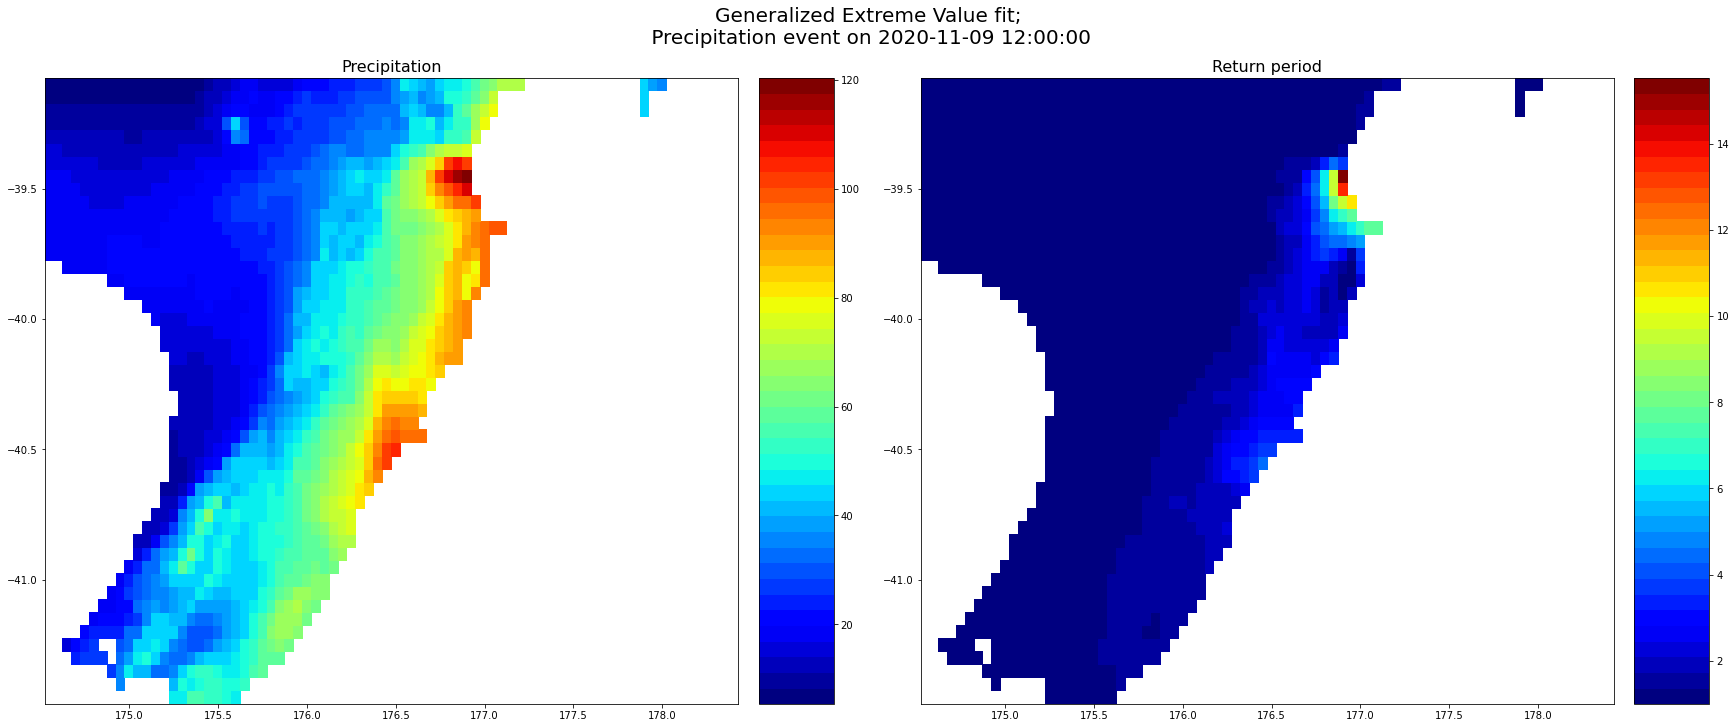

In [8]:
cmap = cm.get_cmap('jet', 40)

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(24, 10))
pc_2 = axs[0].pcolormesh(new_lons, new_lats, data, cmap=cmap)

new_precip = np.full(mask_2.shape, np.nan)
new_precip[mask_2] = precips_2

new_precip = new_precip[lat_idx[0]:lat_idx[1], lon_idx[0]:lon_idx[1]]

pc_2 = axs[1].pcolormesh(new_lons, new_lats, data, cmap=cmap)
precip = axs[0].pcolormesh(new_lons, new_lats, new_precip, cmap=cmap)
    
for i in range(0, 2):
    axs[i].ticklabel_format(useOffset=False, style='plain')
    
cbar1 = fig.colorbar(pc_2, ax=axs[1])
cbar2 = fig.colorbar(precip, ax=axs[0])
    
fig.suptitle(f'Generalized Extreme Value fit;\n Precipitation event on {ds["time"][313].values}', fontsize=20)

axs[1].set_title('Return period', fontsize=16)

if VARKEY == 'tasmax':
    axs[0].set_title('Maximum temperature', fontsize=16)
else:
    axs[0].set_title('Precipitation', fontsize=16)

fig.patch.set_facecolor('white')
plt.savefig(join(r'/mnt/temp/Projects/EWERAM/Data_Keep/Specific_EWEs/20201109_12', 'vcsn_precip.png'))

### Plotting for TASMAX
- Produces 1x2 comparison plot of Tasmax on LHS, return perion on RHS
- Saves to /mnt/temp/Projects/EWERAM/Data_Keep/Specific_EWEs/20201109_12 as vcsn_tasmax.svg
- This plot is over the North Island

<ipython-input-8-b75bd623e859>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc_2 = axs[0].pcolormesh(new_lons, new_lats, data, cmap=cmap)
<ipython-input-8-b75bd623e859>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  precip = axs[0].pcolormesh(new_lons, new_lats, temps, cmap=cmap)
<ipython-input-8-b75bd623e859>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corner

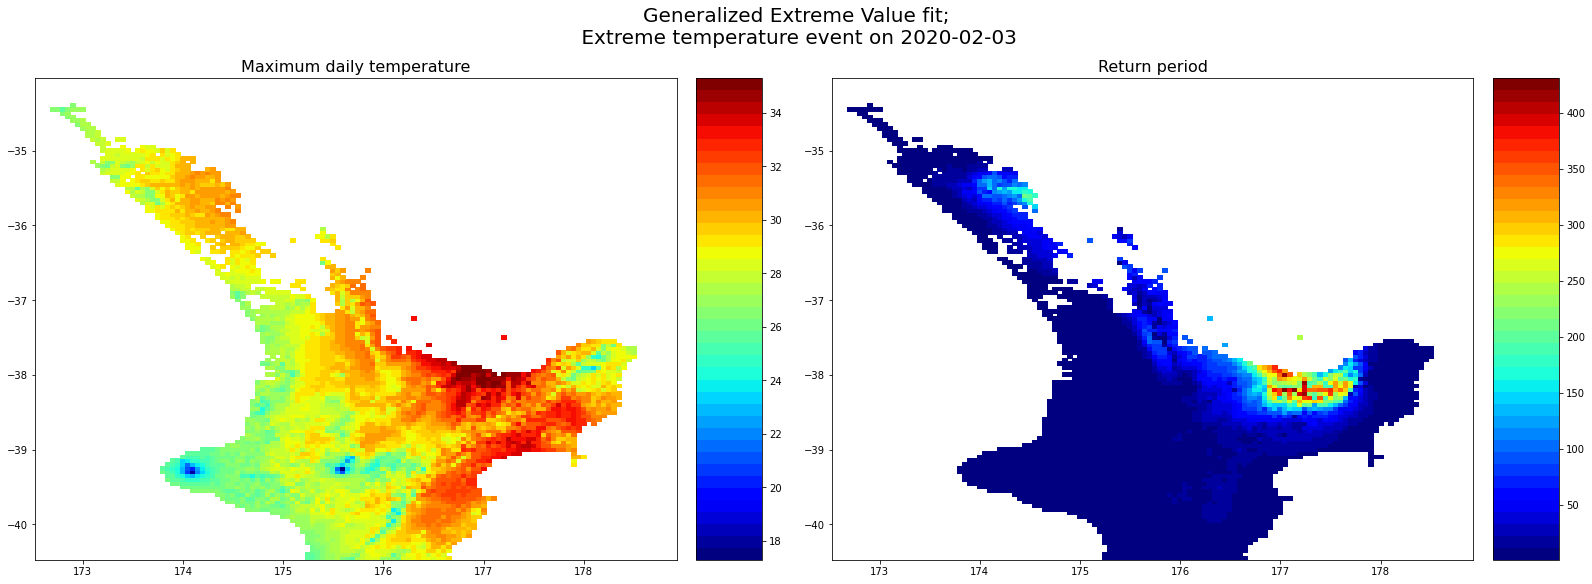

In [8]:
cmap = cm.get_cmap('jet', 40)

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(22, 8))
pc_2 = axs[0].pcolormesh(new_lons, new_lats, data, cmap=cmap)

new_precip = np.full(mask_2.shape, np.nan)
new_precip[mask_2] = precips_2

new_precip = new_precip[lat_idx[0]:lat_idx[1], lon_idx[0]:lon_idx[1]]

temps = new_precip - 273.15

precip = axs[0].pcolormesh(new_lons, new_lats, temps, cmap=cmap)
pc_2 = axs[1].pcolormesh(new_lons, new_lats, data, cmap=cmap)

cbar1 = fig.colorbar(pc_2, ax=axs[1])
cbar2 = fig.colorbar(precip, ax=axs[0])
    
for i in range(0, 2):
    axs[i].ticklabel_format(useOffset=False, style='plain')

fig.suptitle(f'Generalized Extreme Value fit;\n Extreme temperature event on {str(ds["time"][idx].values)[:-9]}', fontsize=20)

axs[1].set_title('Return period', fontsize=16)
axs[0].set_title('Maximum daily temperature', fontsize=16)

fig.patch.set_facecolor('white')
plt.savefig(join(r'/mnt/temp/Projects/EWERAM/Data_Keep/Specific_EWEs/20201109_12', 'vcsn_tmax.png'))

<ipython-input-9-a1aae9dd60c0>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc_2 = axs[0].pcolormesh(new_lons, new_lats, data, cmap=cmap)
<ipython-input-9-a1aae9dd60c0>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  precip = axs[0].pcolormesh(new_lons, new_lats, temps, cmap=cmap)
<ipython-input-9-a1aae9dd60c0>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corner

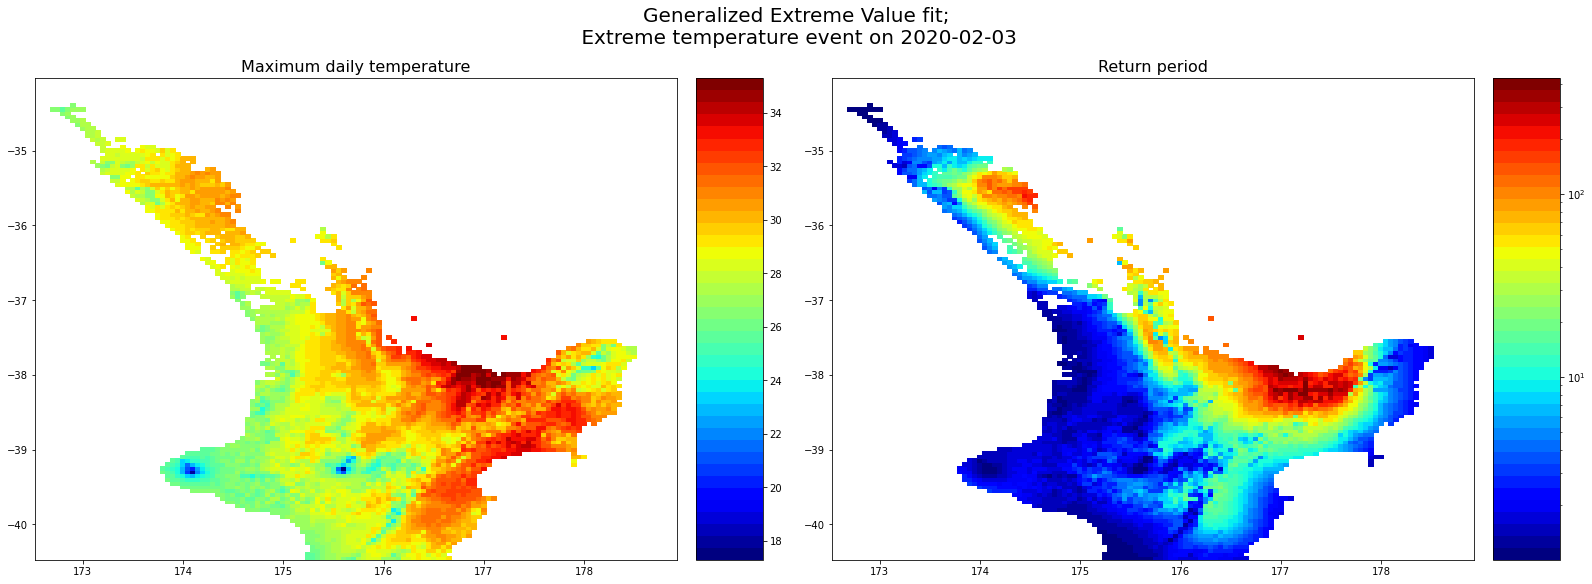

In [9]:
cmap = cm.get_cmap('jet', 40)

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(22, 8))
pc_2 = axs[0].pcolormesh(new_lons, new_lats, data, cmap=cmap)

new_precip = np.full(mask_2.shape, np.nan)
new_precip[mask_2] = precips_2

new_precip = new_precip[lat_idx[0]:lat_idx[1], lon_idx[0]:lon_idx[1]]

temps = new_precip - 273.15

precip = axs[0].pcolormesh(new_lons, new_lats, temps, cmap=cmap)
pc_2 = axs[1].pcolormesh(new_lons, new_lats, data, cmap=cmap, norm=mpl.colors.LogNorm())

cbar1 = fig.colorbar(pc_2, ax=axs[1])
cbar2 = fig.colorbar(precip, ax=axs[0])
    
for i in range(0, 2):
    axs[i].ticklabel_format(useOffset=False, style='plain')

fig.suptitle(f'Generalized Extreme Value fit;\n Extreme temperature event on {str(ds["time"][idx].values)[:-9]}', fontsize=20)

axs[1].set_title('Return period', fontsize=16)
axs[0].set_title('Maximum daily temperature', fontsize=16)

fig.patch.set_facecolor('white')
plt.savefig(join(r'/mnt/temp/Projects/EWERAM/Data_Keep/Specific_EWEs/20201109_12', 'vcsn_tmax_log.png'))

<ipython-input-12-614f1ce87b0e>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc_2 = axs[0].pcolormesh(new_lons, new_lats, data, cmap=cmap)
<ipython-input-12-614f1ce87b0e>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  precip = axs[0].pcolormesh(new_lons, new_lats, temps, cmap=cmap)
<ipython-input-12-614f1ce87b0e>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the cor

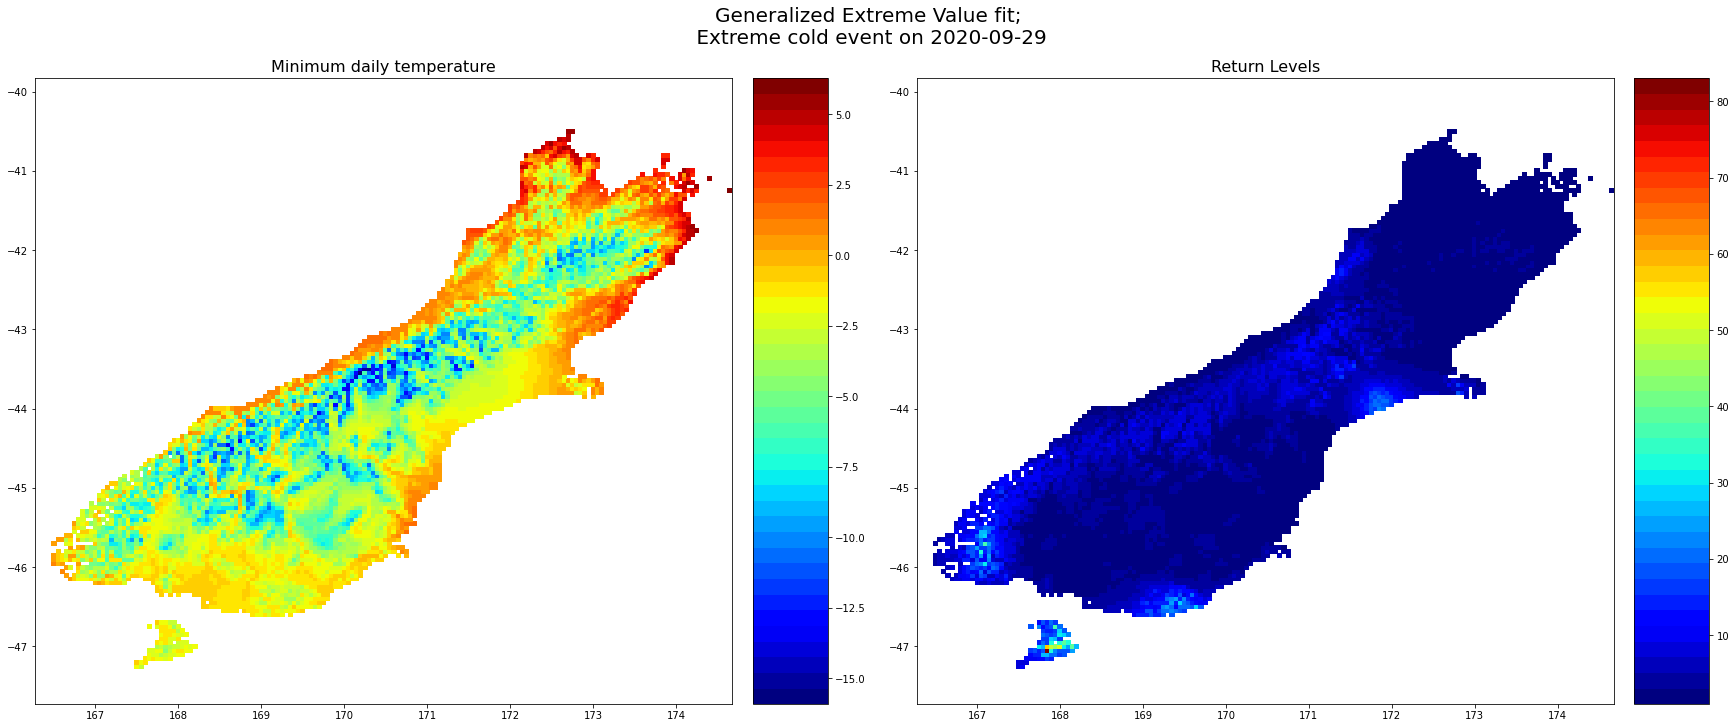

In [12]:
cmap = cm.get_cmap('jet', 40)

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(24, 10))
pc_2 = axs[0].pcolormesh(new_lons, new_lats, data, cmap=cmap)

new_precip = np.full(mask_2.shape, np.nan)
new_precip[mask_2] = precips_2

new_precip = -new_precip[lat_idx[0]:lat_idx[1], lon_idx[0]:lon_idx[1]]
temps = new_precip - 273.15

precip = axs[0].pcolormesh(new_lons, new_lats, temps, cmap=cmap)
pc_2 = axs[1].pcolormesh(new_lons, new_lats, data, cmap=cmap)
    
for i in range(0, 2):
    axs[i].ticklabel_format(useOffset=False, style='plain')
    
cbar1 = fig.colorbar(pc_2, ax=axs[1])
cbar2 = fig.colorbar(precip, ax=axs[0])
    
fig.suptitle(f'Generalized Extreme Value fit;\n Extreme cold event on {str(ds["time"][idx].values)[:-9]}', fontsize=20)

axs[1].set_title('Return Levels', fontsize=16)
axs[0].set_title('Minimum daily temperature', fontsize=16)

fig.patch.set_facecolor('white')
plt.savefig(join(r'/mnt/temp/Projects/EWERAM/Data_Keep/Specific_EWEs/20201109_12', 'vcsn_tmin.svg'))

<ipython-input-11-2157cf697e96>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc_2 = axs[0].pcolormesh(new_lons, new_lats, data, cmap=cmap)
<ipython-input-11-2157cf697e96>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  precip = axs[0].pcolormesh(new_lons, new_lats, temps, cmap=cmap)
<ipython-input-11-2157cf697e96>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the cor

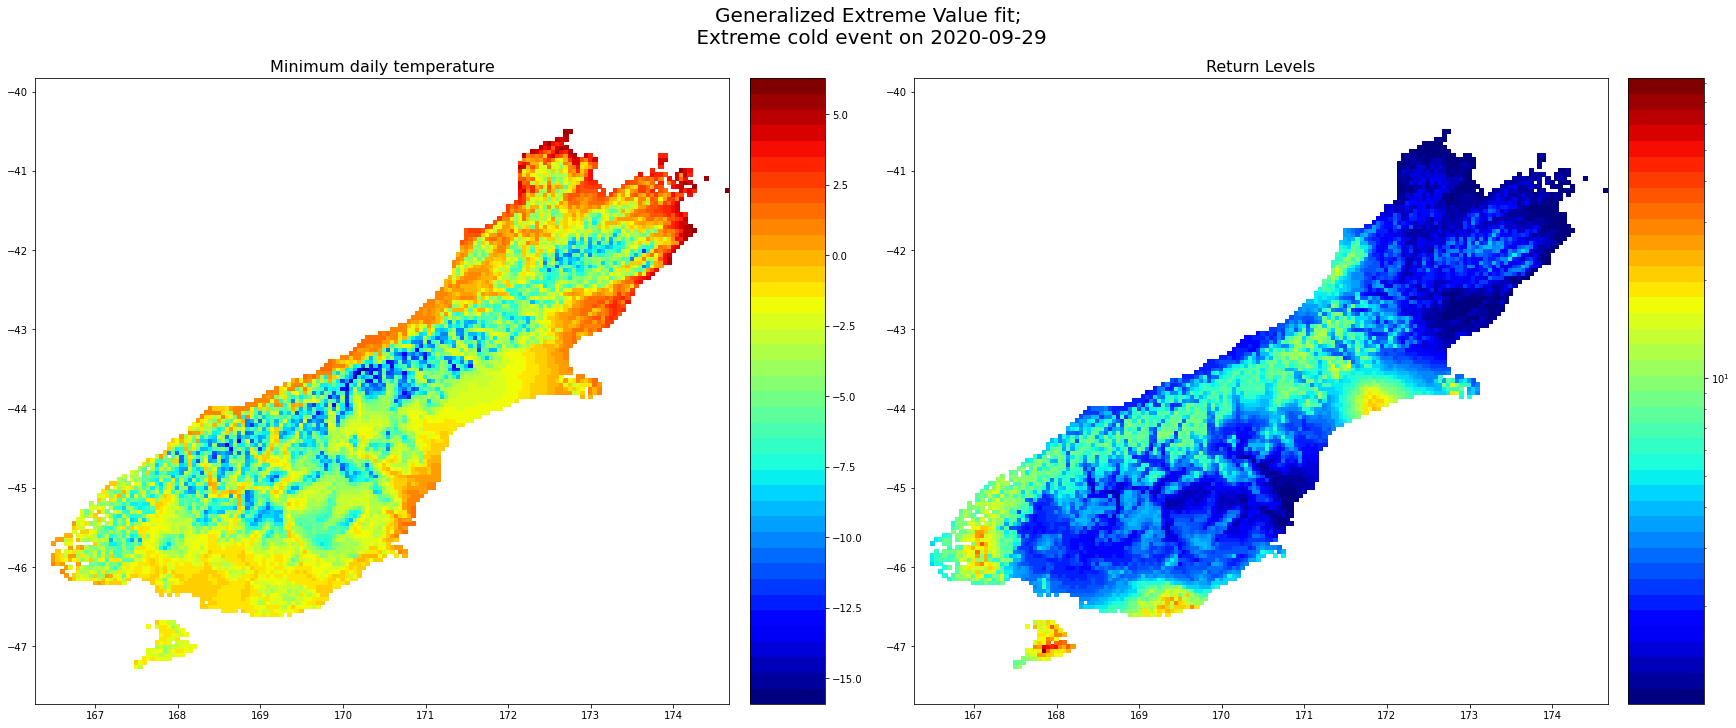

In [11]:
cmap = cm.get_cmap('jet', 40)

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(24, 10))
pc_2 = axs[0].pcolormesh(new_lons, new_lats, data, cmap=cmap)

new_precip = np.full(mask_2.shape, np.nan)
new_precip[mask_2] = precips_2

new_precip = -new_precip[lat_idx[0]:lat_idx[1], lon_idx[0]:lon_idx[1]]
temps = new_precip - 273.15

precip = axs[0].pcolormesh(new_lons, new_lats, temps, cmap=cmap)
pc_2 = axs[1].pcolormesh(new_lons, new_lats, data, cmap=cmap, norm=mpl.colors.LogNorm())
    
for i in range(0, 2):
    axs[i].ticklabel_format(useOffset=False, style='plain')
    
cbar1 = fig.colorbar(pc_2, ax=axs[1])
cbar2 = fig.colorbar(precip, ax=axs[0])
    
fig.suptitle(f'Generalized Extreme Value fit;\n Extreme cold event on {str(ds["time"][idx].values)[:-9]}', fontsize=20)

axs[1].set_title('Return Levels', fontsize=16)
axs[0].set_title('Minimum daily temperature', fontsize=16)

fig.patch.set_facecolor('white')
plt.savefig(join(r'/mnt/temp/Projects/EWERAM/Data_Keep/Specific_EWEs/20201109_12', 'vcsn_tmin_log.svg'))